# Install modules

In [1]:
# !pip install simplejson
from types import SimpleNamespace
import os
import re
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import shap
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

# Function to read .PSSESSION files

In [2]:
import json
import pandas as pd
import numpy as np

def extract_eis_data(file_path):
    # Read and parse JSON
    json_str = ""
    try:
        with open(file_path, 'r', encoding='utf-16') as f:
            content = f.read()
            brace_count = 0
            start = None
            for i, char in enumerate(content):
                if char == '{':
                    if brace_count == 0:
                        start = i
                    brace_count += 1
                elif char == '}':
                    brace_count -= 1
                    if brace_count == 0:
                        json_str = content[start:i+1]
                        break
            if not json_str:
                raise ValueError("No valid JSON object found in the file.")
        data = json.loads(json_str)
    except json.JSONDecodeError as e:
        print(f"JSON parsing error: {e}")
        raise
    except Exception as e:
        print(f"Error reading file: {e}")
        raise

    # Extract EIS data
    values = data["Measurements"][0]["DataSet"]["Values"]
    description_to_column = {
        "Frequency": "Frequency/Hz",
        "Z": "Z/Ohm",
        "ZRe": "ZRe/Ohm",
        "ZIm": "-ZIm/Ohm",
        "Phase": "-Phase/Degr",
        "Capacitance": "Cs/F"
    }
    eis_data = {}
    for value in values:
        desc = value["Description"]
        if desc in description_to_column:
            key = description_to_column[desc]
            eis_data[key] = [item["V"] for item in value["DataValues"]]

    # Create DataFrame
    df = pd.DataFrame(eis_data)

    # Calculate real and imaginary parts of capacitance
    f = df['Frequency/Hz'].values
    Z_re = df['ZRe/Ohm'].values
    Z_im = df['-ZIm/Ohm'].values  # -Z'', where Z = Z_re - j Z'' and Z'' = -Z_im
    omega = 2 * np.pi * f
    Z = Z_re + 1j * -1 * Z_im
    C = 1 / (1j * omega * Z)
    df['CRe/F'] = C.real
    df['-CIm/F'] = -C.imag

    return df

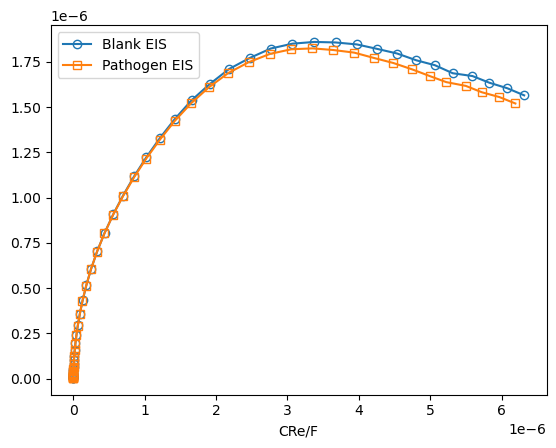

In [3]:
# Example usage:
df_blank_EIS = extract_eis_data('EIS Data/BLANK_EIS.pssession')
df_pathogen_EIS = extract_eis_data('EIS Data/PATHOGEN_EIS.pssession')

# display(df1)
ax1 = df_blank_EIS.plot('CRe/F', '-CIm/F', label="Blank EIS", marker='o',linestyle='-',markerfacecolor='none',markeredgecolor='C0')
df_pathogen_EIS.plot('CRe/F', '-CIm/F', ax = ax1, label="Pathogen EIS", marker='s',linestyle='-',markerfacecolor='none',markeredgecolor='C1')
plt.legend()

# Calculating pathogen concentration using the pre-established calibration curve equation, blank EIS scan data, and pathogen EIS scan data; all at a fixed frequency.

In [6]:
analysis_frequency = 10

blank_Capacitance = df_blank_EIS[df_blank_EIS['Frequency/Hz']==10]['Cs/F'].values[0]
display(f"Total blank capacitance at {analysis_frequency} Hz = {blank_Capacitance}")
print("\n")

pathogen_Capacitance = df_pathogen_EIS[df_pathogen_EIS['Frequency/Hz']==10]['Cs/F'].values[0]
display(f"Total pathogen capacitance at {analysis_frequency} Hz = {pathogen_Capacitance}")
print("\n")

percent_delta_C = 100*(pathogen_Capacitance - blank_Capacitance)/blank_Capacitance
display(f"Percent change in capacitance at {analysis_frequency} Hz = {percent_delta_C} %")
print("\n")

### Converting percent_delta_C to pathogen_conc Using Pre-established Calibration Curve
# Need Pre-established calibration curve (based on Total capacitance (Cs/F) and at a fixed frequency) 
# Example calibration curve: y = -0.126*ln(x) - 0.421; where, y=percent_delta_C and x=pathogen_conc

pathogen_conc = np.exp((percent_delta_C + 0.421)/(-0.126))
display(f"Pathogen concentration based on calibration curve = {pathogen_conc}")

'Total blank capacitance at 10 Hz = 4.6115866873576534e-06'

'Total pathogen capacitance at 10 Hz = 4.546041045791207e-06'

'Percent change in capacitance at 10 Hz = -1.4213251535775244 %'

'Pathogen concentration based on calibration curve = 2804.8028224424133'